# Expected Loss Model

Dự án này tập trung vào việc xây dựng mô hình tổn thất dự kiến, một thành phần quan trọng trong quản lý rủi ro cho các tổ chức tài chính như ngân hàng. Bằng cách tận dụng dữ liệu lịch sử và các kỹ thuật thống kê tiên tiến, mô hình này nhằm mục đích ước tính những tổn thất tiềm ẩn liên quan đến các khoản vay. Những mô hình như vậy đóng vai trò quan trọng trong việc đánh giá rủi ro tín dụng, thiết lập dự trữ phù hợp và đảm bảo sự ổn định tài chính trong điều kiện kinh tế không chắc chắn.

Công thức tính Tổn thất dự kiến (Expected Loss):

**EL = PD x LGD x EAD**

Trong đó
- EL: Tổn thất dự kiến (Expected Loss)
- PD: Xác suất vỡ nợ (Probability of Default)
- LGD: tỉ trọng tổn thất ước tính (Loss Given Default) = (EAD - Số tiền có thể thu hồi)/EAD
- EAD: Tổng dư nợ của khách hàng tại thời điểm không trả được nợ (Exposure at Default)

Trong trường hợp này, ta không có đủ dữ liệu để tính "Số tiền có thể thu hồi", ta giả sử các khoản nợ đều không thể thu hồi do đó LGD = 1 và EAD bằng chính số tiền đã vay

Link datasets: https://www.kaggle.com/datasets/nurudeenabdulsalaam/prosper-loan-dataset

## 1. Load dữ liệu

In [1]:
# Import thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df=pd.read_csv('loan_default.csv')
df.head()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
0,1021339766868145413AB3B,193129,09:29.3,C,36,Completed,14/08/2009 00:00,0.16516,0.1580,0.1380,...,-133.18,0.0,0.0,0.0,0.0,1.0,0,0,0.0,258
1,10273602499503308B223C1,1209647,28:07.9,NaN,36,Current,NaN,0.12016,0.0920,0.0820,...,0.00,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
2,0EE9337825851032864889A,81716,00:47.1,HR,36,Completed,17/12/2009 00:00,0.28269,0.2750,0.2400,...,-24.20,0.0,0.0,0.0,0.0,1.0,0,0,0.0,41
3,0EF5356002482715299901A,658116,02:35.0,NaN,36,Current,NaN,0.12528,0.0974,0.0874,...,-108.01,0.0,0.0,0.0,0.0,1.0,0,0,0.0,158
4,0F023589499656230C5E3E2,909464,38:39.1,NaN,36,Current,NaN,0.24614,0.2085,0.1985,...,-60.27,0.0,0.0,0.0,0.0,1.0,0,0,0.0,20


**Mô tả về các biến có trong tập dữ liệu**

Do dữ liệu gốc có rất nhiều features, để tiện trong việc xây dựng mô hình, dự án này sẽ sử dụng một vài feature chính:

In [3]:
description=pd.read_excel('data_description.xlsx', sheet_name='Sheet1')
description

,Tên biến,Mô tả
0,EmploymentStatus,Tình trạng nghề nghiệp
1,IsBorrowerHomeowner,Người vay có sở hữu nhà không?
2,Term,Thời hạn khoản vay
3,LoanOriginalAmount,Số tiền vay
4,BorrowerAPR,Lãi suất hàng năm
5,LenderYield,Lợi suất nợ
6,MonthlyLoanPayment,Số tiền phải trả hàng tháng
7,IncomeVerifiable,Người vay có tài liệu để chứng minh thu nhập
8,StatedMonthlyIncome,Thu nhập hàng tháng của người vay
9,DebtToIncomeRatio,Tỉ lệ nợ trên thu nhập của người vay


In [4]:
# Lấy các features cần thiết
df=df[['EmploymentStatus', 'IsBorrowerHomeowner', 'Term', 'LoanOriginalAmount', 'BorrowerAPR', 'LenderYield', 'MonthlyLoanPayment',
       'IncomeVerifiable', 'StatedMonthlyIncome', 'DebtToIncomeRatio', 'TotalInquiries', 'CurrentCreditLines', 'OpenRevolvingAccounts', 'OpenRevolvingMonthlyPayment', 'LoanStatus']]
df.head()

,EmploymentStatus,IsBorrowerHomeowner,Term,LoanOriginalAmount,BorrowerAPR,LenderYield,MonthlyLoanPayment,IncomeVerifiable,StatedMonthlyIncome,DebtToIncomeRatio,TotalInquiries,CurrentCreditLines,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,LoanStatus
0,Self-employed,True,36,9425,0.16516,0.1380,330.43,True,3083.333333,0.17,3.0,5.0,1,24,Completed
1,Employed,False,36,10000,0.12016,0.0820,318.93,True,6125.000000,0.18,5.0,14.0,13,389,Current
2,Not available,False,36,3001,0.28269,0.2400,123.32,True,2083.333333,0.06,1.0,NaN,0,0,Completed
3,Employed,True,36,10000,0.12528,0.0874,321.45,True,2875.000000,0.15,1.0,5.0,7,115,Current
4,Employed,True,36,15000,0.24614,0.1985,563.97,True,9583.333333,0.26,9.0,19.0,6,220,Current


## 2. Khám phá dữ liệu - EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 15 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   EmploymentStatus             111682 non-null  object 
 1   IsBorrowerHomeowner          113937 non-null  bool   
 2   Term                         113937 non-null  int64  
 3   LoanOriginalAmount           113937 non-null  int64  
 4   BorrowerAPR                  113912 non-null  float64
 5   LenderYield                  113937 non-null  float64
 6   MonthlyLoanPayment           113937 non-null  float64
 7   IncomeVerifiable             113937 non-null  bool   
 8   StatedMonthlyIncome          113937 non-null  float64
 9   DebtToIncomeRatio            105383 non-null  float64
 10  TotalInquiries               112778 non-null  float64
 11  CurrentCreditLines           106333 non-null  float64
 12  OpenRevolvingAccounts        113937 non-null  int64  
 13 

In [7]:
df.describe()

,Term,LoanOriginalAmount,BorrowerAPR,LenderYield,MonthlyLoanPayment,StatedMonthlyIncome,DebtToIncomeRatio,TotalInquiries,CurrentCreditLines,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment
count,113937.000000,113937.00000,113912.000000,113937.000000,113937.000000,1.139370e+05,105383.000000,112778.000000,106333.000000,113937.00000,113937.000000
mean,40.830248,8337.01385,0.218828,0.182701,272.475783,5.608026e+03,0.275947,5.584405,10.317192,6.96979,398.292161
std,10.436212,6245.80058,0.080364,0.074516,192.697812,7.478497e+03,0.551759,6.429946,5.457866,4.63097,447.159711
min,12.000000,1000.00000,0.006530,-0.010000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.00000,0.000000
25%,36.000000,4000.00000,0.156290,0.124200,131.620000,3.200333e+03,0.140000,2.000000,7.000000,4.00000,114.000000
50%,36.000000,6500.00000,0.209760,0.173000,217.740000,4.666667e+03,0.220000,4.000000,10.000000,6.00000,271.000000
75%,36.000000,12000.00000,0.283810,0.240000,371.580000,6.825000e+03,0.320000,7.000000,13.000000,9.00000,525.000000
max,60.000000,35000.00000,0.512290,0.492500,2251.510000,1.750003e+06,10.010000,379.000000,59.000000,51.00000,14985.000000


In [8]:
df.isnull().sum()

EmploymentStatus               2255
IsBorrowerHomeowner               0
Term                              0
LoanOriginalAmount                0
BorrowerAPR                      25
LenderYield                       0
MonthlyLoanPayment                0
IncomeVerifiable                  0
StatedMonthlyIncome               0
DebtToIncomeRatio              8554
TotalInquiries                 1159
CurrentCreditLines             7604
OpenRevolvingAccounts             0
OpenRevolvingMonthlyPayment       0
LoanStatus                        0
dtype: int64

Có 5 cột chứa giá trị null, trong đó cột DebtToIncomeRatio và CurrentCreditLines chiếm số lượng nhiều nhất

In [9]:
# Xử lý missing data
df['EmploymentStatus']=df['EmploymentStatus'].fillna(value='Other') # Gộp các giá trị còn thiếu ở cột EmploymentStatus thành Other

df['TotalInquiries']=df['TotalInquiries'].fillna(value=0) # Điền 0 cho cột TotalInquiries

# Do không đủ dữ kiện nên trường hợp này sẽ tính DTI bằng cách lấy số tiền phải trả hàng tháng chia cho thu nhập hàng tháng
# Để tránh việc tính ra DTI bị lỗi, ta sẽ điền DTI=0 với các dòng có StateMonthlyIncome=0
def fill_na(row):
    if pd.isnull(row['DebtToIncomeRatio']):
        if row['StatedMonthlyIncome']==0:
            return 0
        else: return row['MonthlyLoanPayment']/row['StatedMonthlyIncome']
    return row['DebtToIncomeRatio']


df['DebtToIncomeRatio']=df.apply(fill_na, axis=1)

df['CurrentCreditLines']=df['CurrentCreditLines'].fillna(value=df['CurrentCreditLines'].mean().round(0)) # Điền giá trị trung bình cho cột CurrentCreditLines

df=df.dropna(subset='BorrowerAPR') # Xóa các dòng chứa giá trị null ở cột BorrowerAPR do có ít giá trị null

In [10]:
# Đếm số lượng khách hàng theo tình trạng khoản vay
df['LoanStatus'].value_counts()

LoanStatus
Current                   56576
Completed                 38049
Chargedoff                11992
Defaulted                  5018
Past Due (1-15 days)        806
Past Due (31-60 days)       363
Past Due (61-90 days)       313
Past Due (91-120 days)      304
Past Due (16-30 days)       265
FinalPaymentInProgress      205
Past Due (>120 days)         16
Cancelled                     5
Name: count, dtype: int64

Do cột LoanStatus có khá nhiều trạng thái, dự án này tập trung chủ yếu vào việc dự đoán khách hàng bị vỡ nợ.

- Defaulted: Các khoản vay bị vỡ nợ, người vay không thể trả được và người cho vay tiến hành các biện pháp thu hồi nợ
- Charged off: Các khoản vay đã bị vỡ nợ trong một thời gian dài và không có khả năng thu hồi

Với việc giả định các khoản vay đều không thể thu hồi được nên Charged off và Defaulted là tương đương nhau nên sẽ chuyển thành 1: Defaulted, các giá trị khác còn lại là 0: No Defaulted

In [11]:
df['LoanStatus']=np.where((df['LoanStatus']=='Defaulted') | (df['LoanStatus']=='Chargedoff'), 1, 0)

LoanStatus
0    96902
1    17010
Name: count, dtype: int64
LoanStatus
0    85.06742
1    14.93258
Name: count, dtype: float64


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_7024\1071903339.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(['No Default', 'Default'])


''

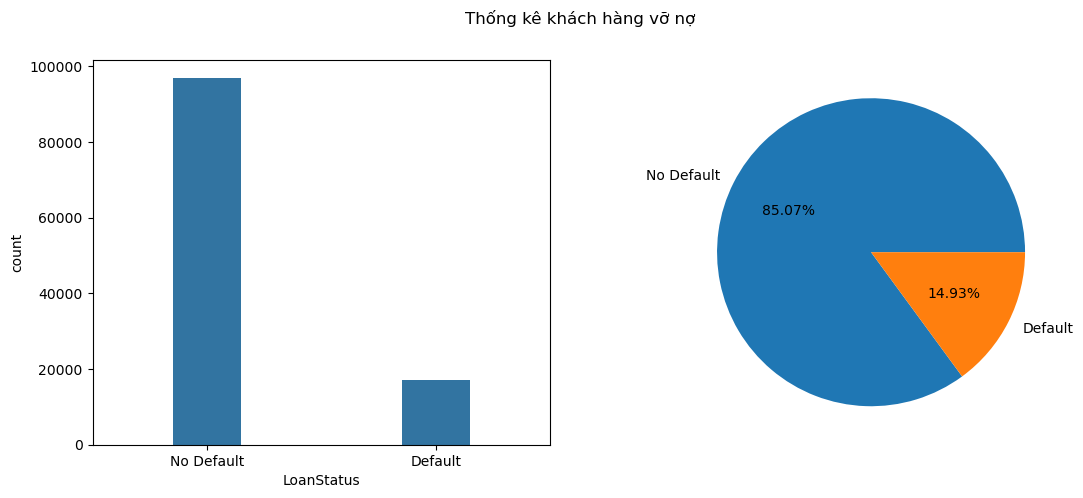

In [12]:
# Thống kê số lượng khách hàng vỡ nợ
default_count=df['LoanStatus'].value_counts()
print(default_count)
default_pct=default_count/default_count.sum()*100
print(default_pct)

# Visualize
fig, ax=plt.subplots(1,2, figsize=(13,5))
ax1=sns.countplot(data=df, x='LoanStatus', width=0.3, ax=ax[0])
ax2=ax[1].pie(default_pct, labels=['No Default', 'Default'], autopct='%.2f%%')
ax1.set_xticklabels(['No Default', 'Default'])
plt.suptitle('Thống kê khách hàng vỡ nợ')
;

Từ hai hình trên, có thể thấy phần lớn các khoản vay đều không phải là vỡ nợ, chỉ có khoảng gần 15% khoản vay được xác định là vỡ nợ. Ngoài ra dựa vào kết quả trên cho thấy dữ liệu bị mất cân bằng (imbalanced data) giữa lớp vỡ nợ so với lớp không vỡ nợ.

In [13]:
# Phân chia các features
cat_cols=df.select_dtypes(include='object')
num_cols=df.select_dtypes(exclude='object')

In [15]:
# Check outliers (sử dụng IQR method)
for col in num_cols.drop(columns=['LoanStatus', 'IsBorrowerHomeowner', 'IncomeVerifiable']).columns:
    q1=np.percentile(df[col], 25)
    q3=np.percentile(df[col], 75)
    iqr=q3-q1
    low=q1-1.5*iqr
    high=q3+1.5*iqr
    outliers_df=df[((df[col]>high) | (df[col]<low))]

print('Số dòng chứa outliers: %s (%s)' % (len(outliers_df), round((len(outliers_df)/len(df)*100), 2)))

Số dòng chứa outliers: 6743 (5.92)


Do số lượng outliers chiếm khá ít so với tổng dữ liệu gốc nên để đơn giản thì ta sẽ xóa đi các giá trị outliers

In [16]:
# Xóa các outliers
for col in num_cols.drop(columns=['LoanStatus', 'IsBorrowerHomeowner', 'IncomeVerifiable']).columns:
    q1=np.percentile(df[col], 25)
    q3=np.percentile(df[col], 75)
    iqr=q3-q1
    low=q1-1.5*iqr
    high=q3+1.5*iqr
    new_df=df[((df[col]<=high) & (df[col]>=low))]

len(new_df)

107169

### Phân tích đơn biến (Univariate analysis)

EmploymentStatus
Employed         63166
Full-time        24872
Other             5845
Self-employed     5480
Not available     5159
Part-time         1071
Not employed       808
Retired            768
Name: count, dtype: int64


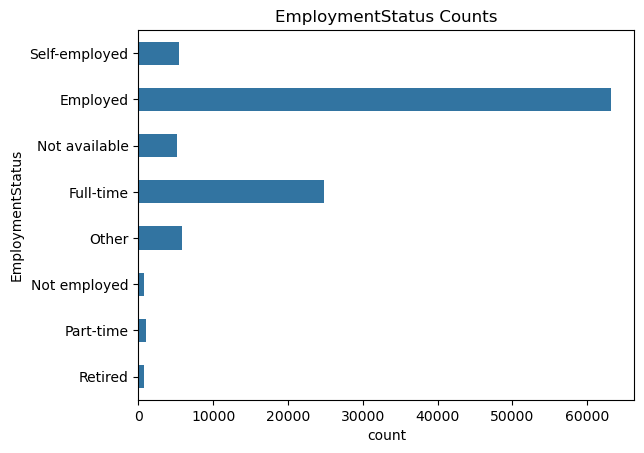

In [17]:
# Visualize các features category
print(new_df['EmploymentStatus'].value_counts())
sns.countplot(data=new_df, y='EmploymentStatus', width=0.5, orient='h')
plt.title('EmploymentStatus Counts')
plt.show()

Với kết quả trên, phần lớn khách hàng là những người đã có việc làm, ngoài ra số người làm việc full-time chiếm số lượng khá lớn trong khi những tình trạng việc làm khác là khá ít.

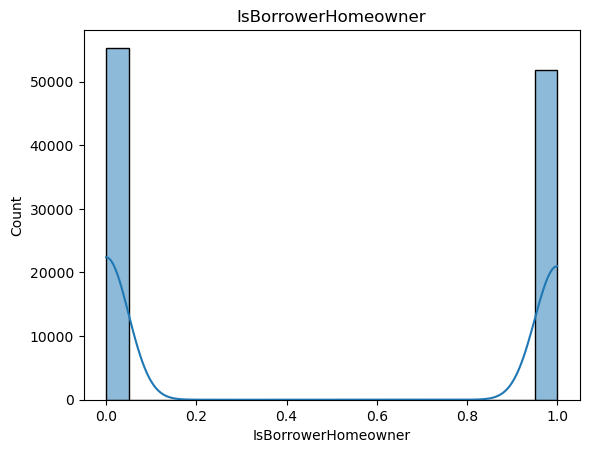

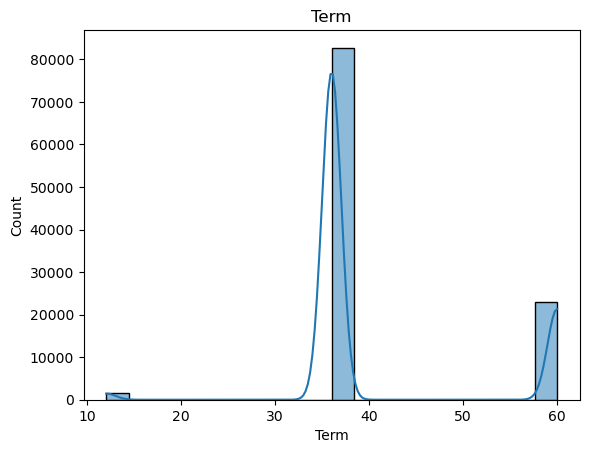

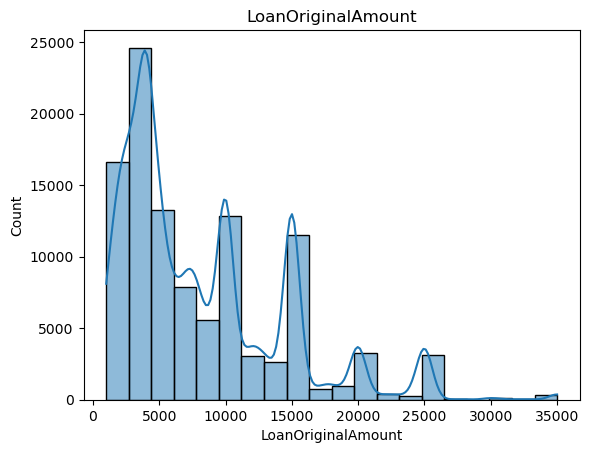

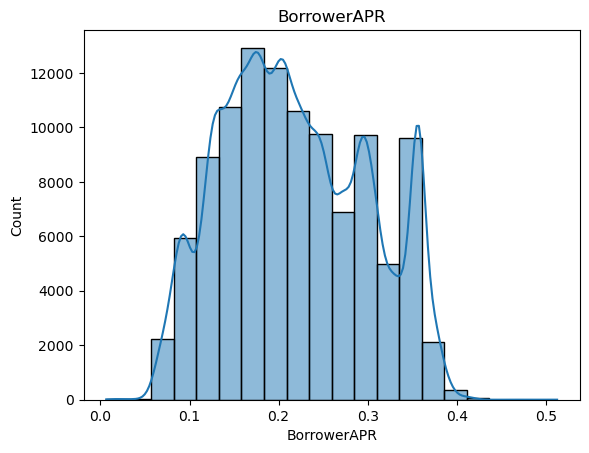

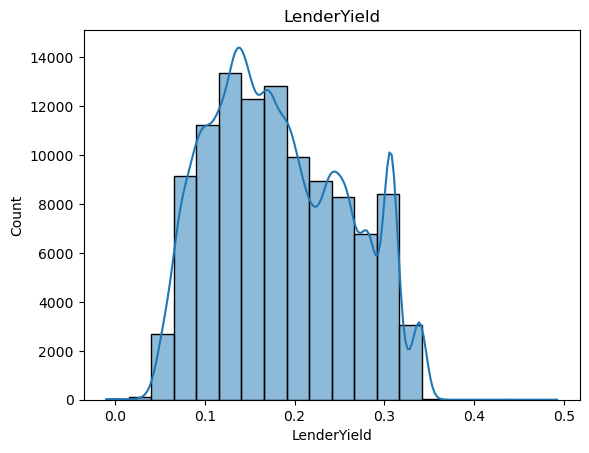

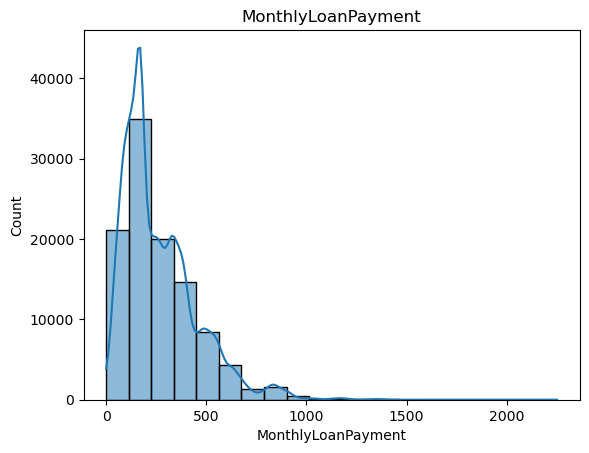

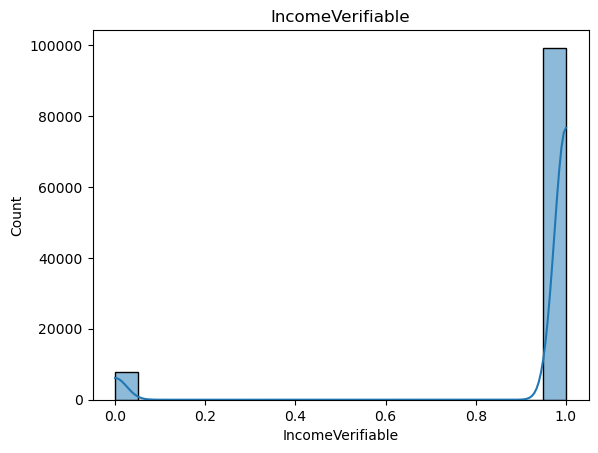

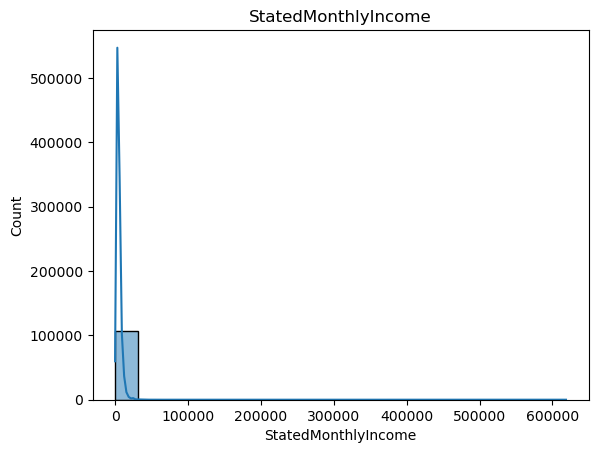

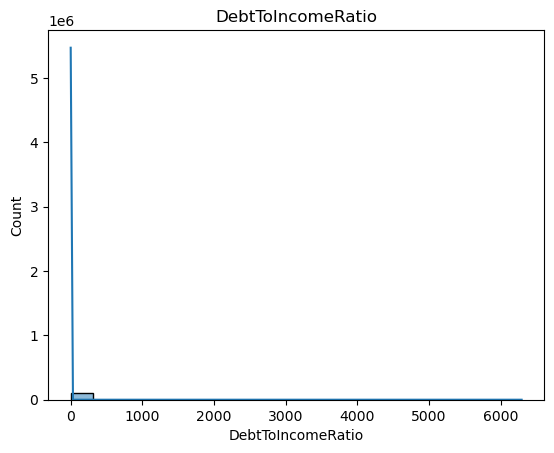

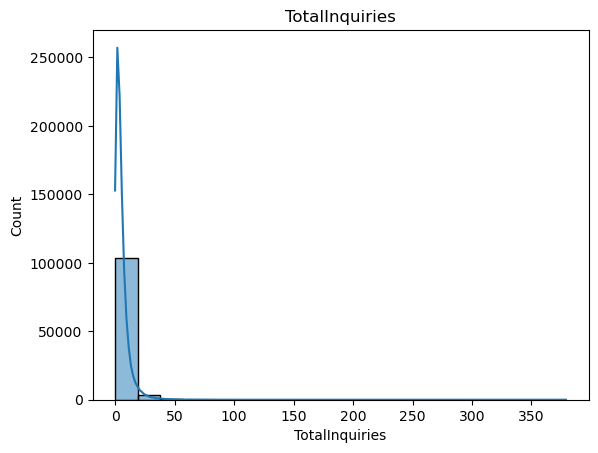

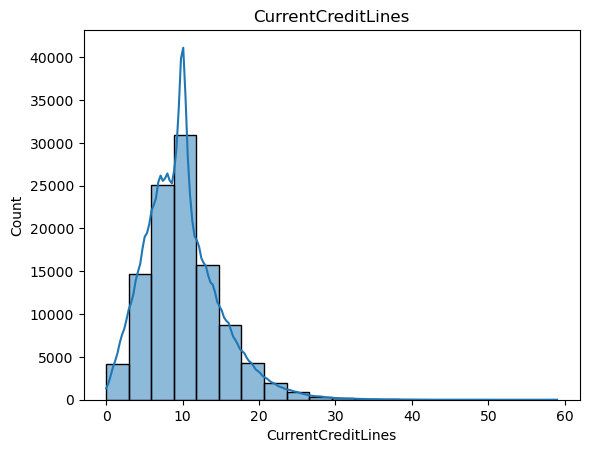

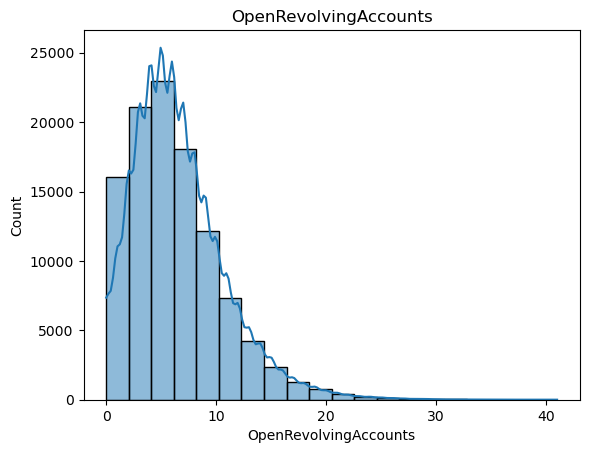

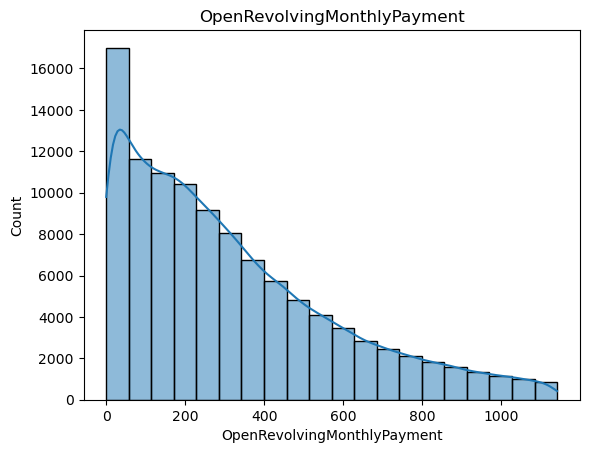

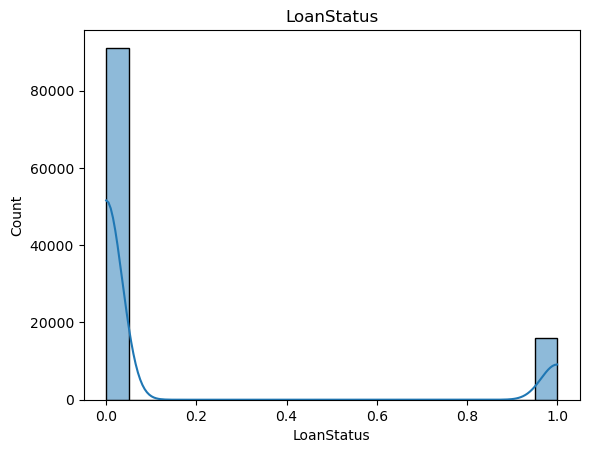

In [18]:
# Visualize các features numeric
for col in num_cols.columns:
    sns.histplot(data=new_df, x=col, kde=True, bins=20)
    plt.title(col)
    plt.show()

### Phân tích hai biến (Bivariate analysis)

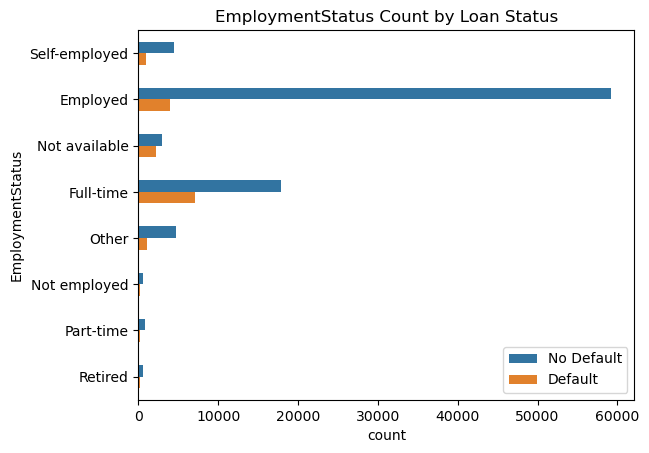

In [19]:
# Visualize các features category
sns.countplot(data=new_df, y='EmploymentStatus', hue='LoanStatus', width=0.5, orient='h')
plt.title('EmploymentStatus Count by Loan Status')
plt.legend(['No Default', 'Default'], loc='lower right');

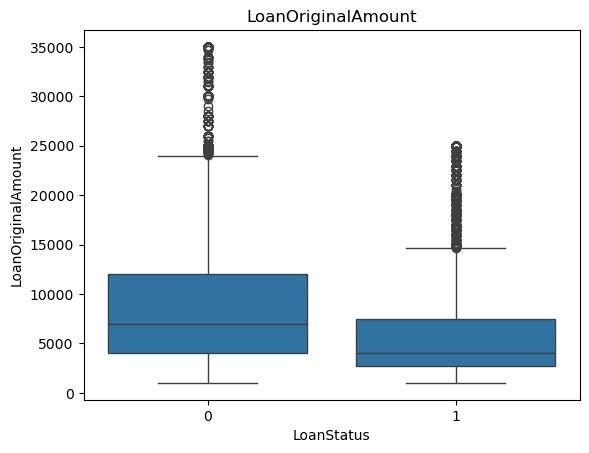

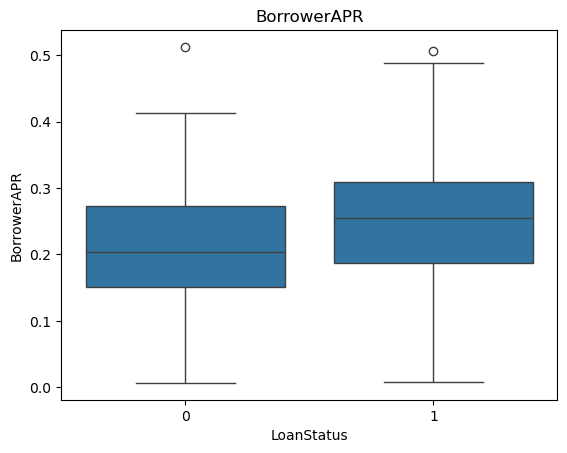

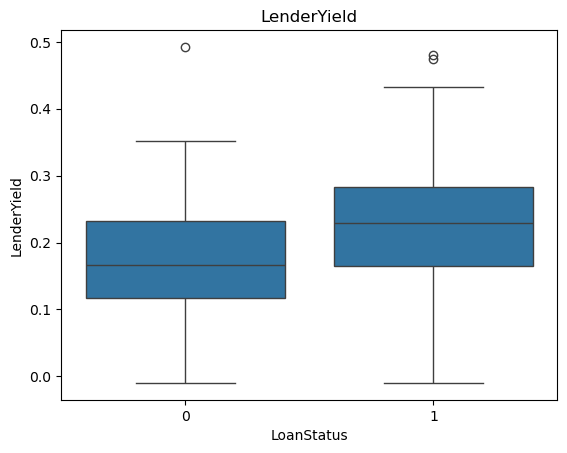

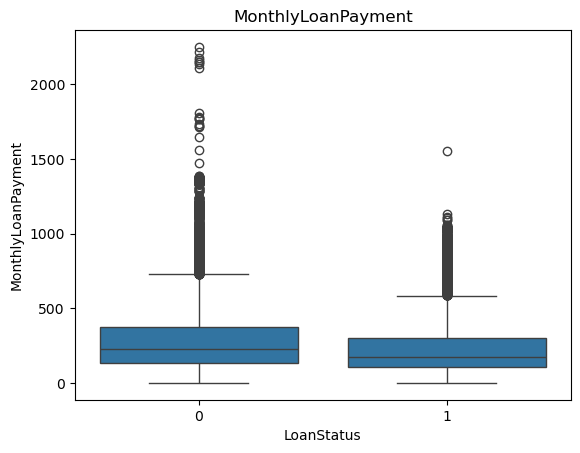

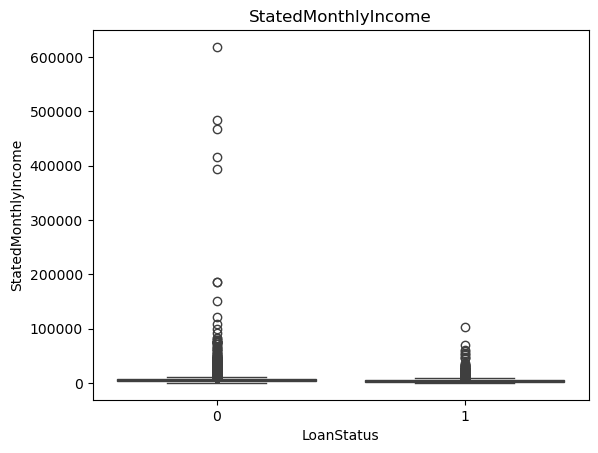

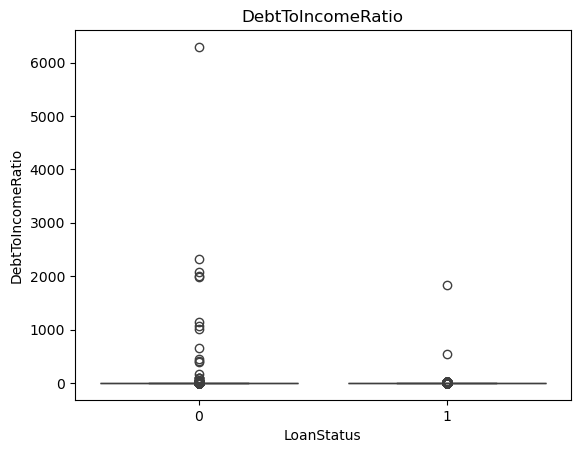

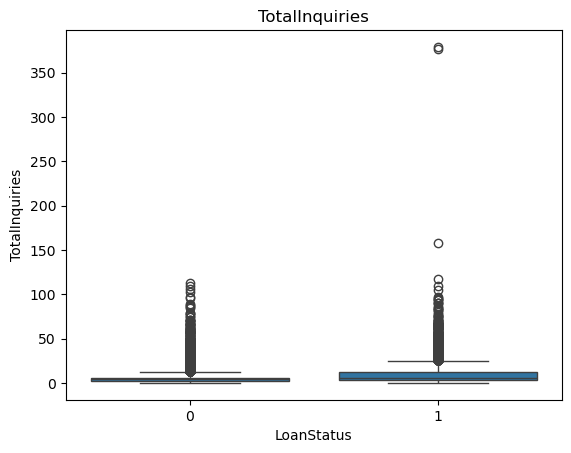

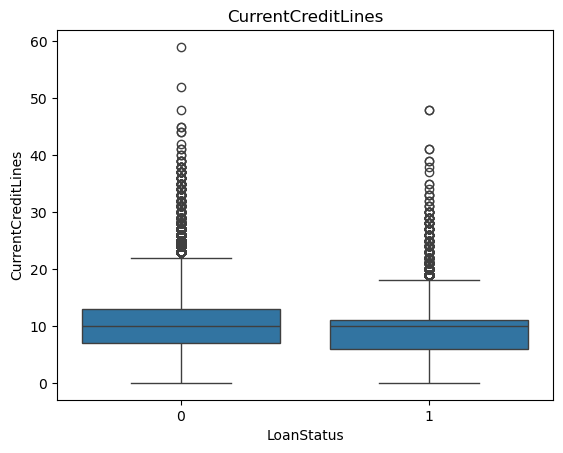

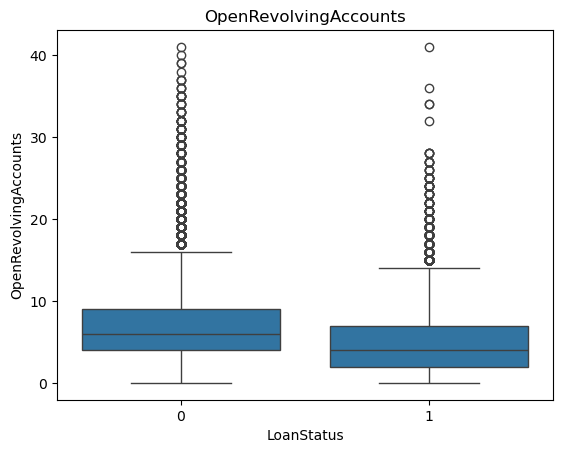

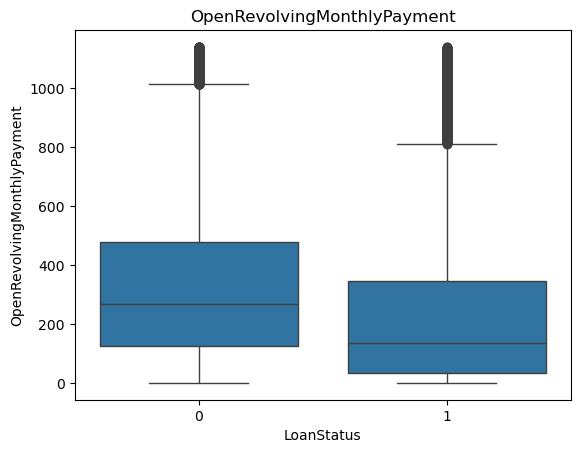

In [20]:
# Visualize các features numeric
for col in num_cols.drop(columns=['LoanStatus', 'IsBorrowerHomeowner', 'Term', 'IncomeVerifiable']).columns:
    sns.boxplot(data=new_df, x='LoanStatus', y=col)
    plt.title(col)
    plt.show()

### Phân tích đa biến (Multivariate analysis)

In [21]:
# Encoding feature category
new_df_dummy=pd.get_dummies(data=new_df, drop_first=True, dtype=int)
new_df_dummy.head()

,IsBorrowerHomeowner,Term,LoanOriginalAmount,BorrowerAPR,LenderYield,MonthlyLoanPayment,IncomeVerifiable,StatedMonthlyIncome,DebtToIncomeRatio,TotalInquiries,...,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,LoanStatus,EmploymentStatus_Full-time,EmploymentStatus_Not available,EmploymentStatus_Not employed,EmploymentStatus_Other,EmploymentStatus_Part-time,EmploymentStatus_Retired,EmploymentStatus_Self-employed
0,True,36,9425,0.16516,0.1380,330.43,True,3083.333333,0.17,3.0,...,1,24,0,0,0,0,0,0,0,1
1,False,36,10000,0.12016,0.0820,318.93,True,6125.000000,0.18,5.0,...,13,389,0,0,0,0,0,0,0,0
2,False,36,3001,0.28269,0.2400,123.32,True,2083.333333,0.06,1.0,...,0,0,0,0,1,0,0,0,0,0
3,True,36,10000,0.12528,0.0874,321.45,True,2875.000000,0.15,1.0,...,7,115,0,0,0,0,0,0,0,0
4,True,36,15000,0.24614,0.1985,563.97,True,9583.333333,0.26,9.0,...,6,220,0,0,0,0,0,0,0,0


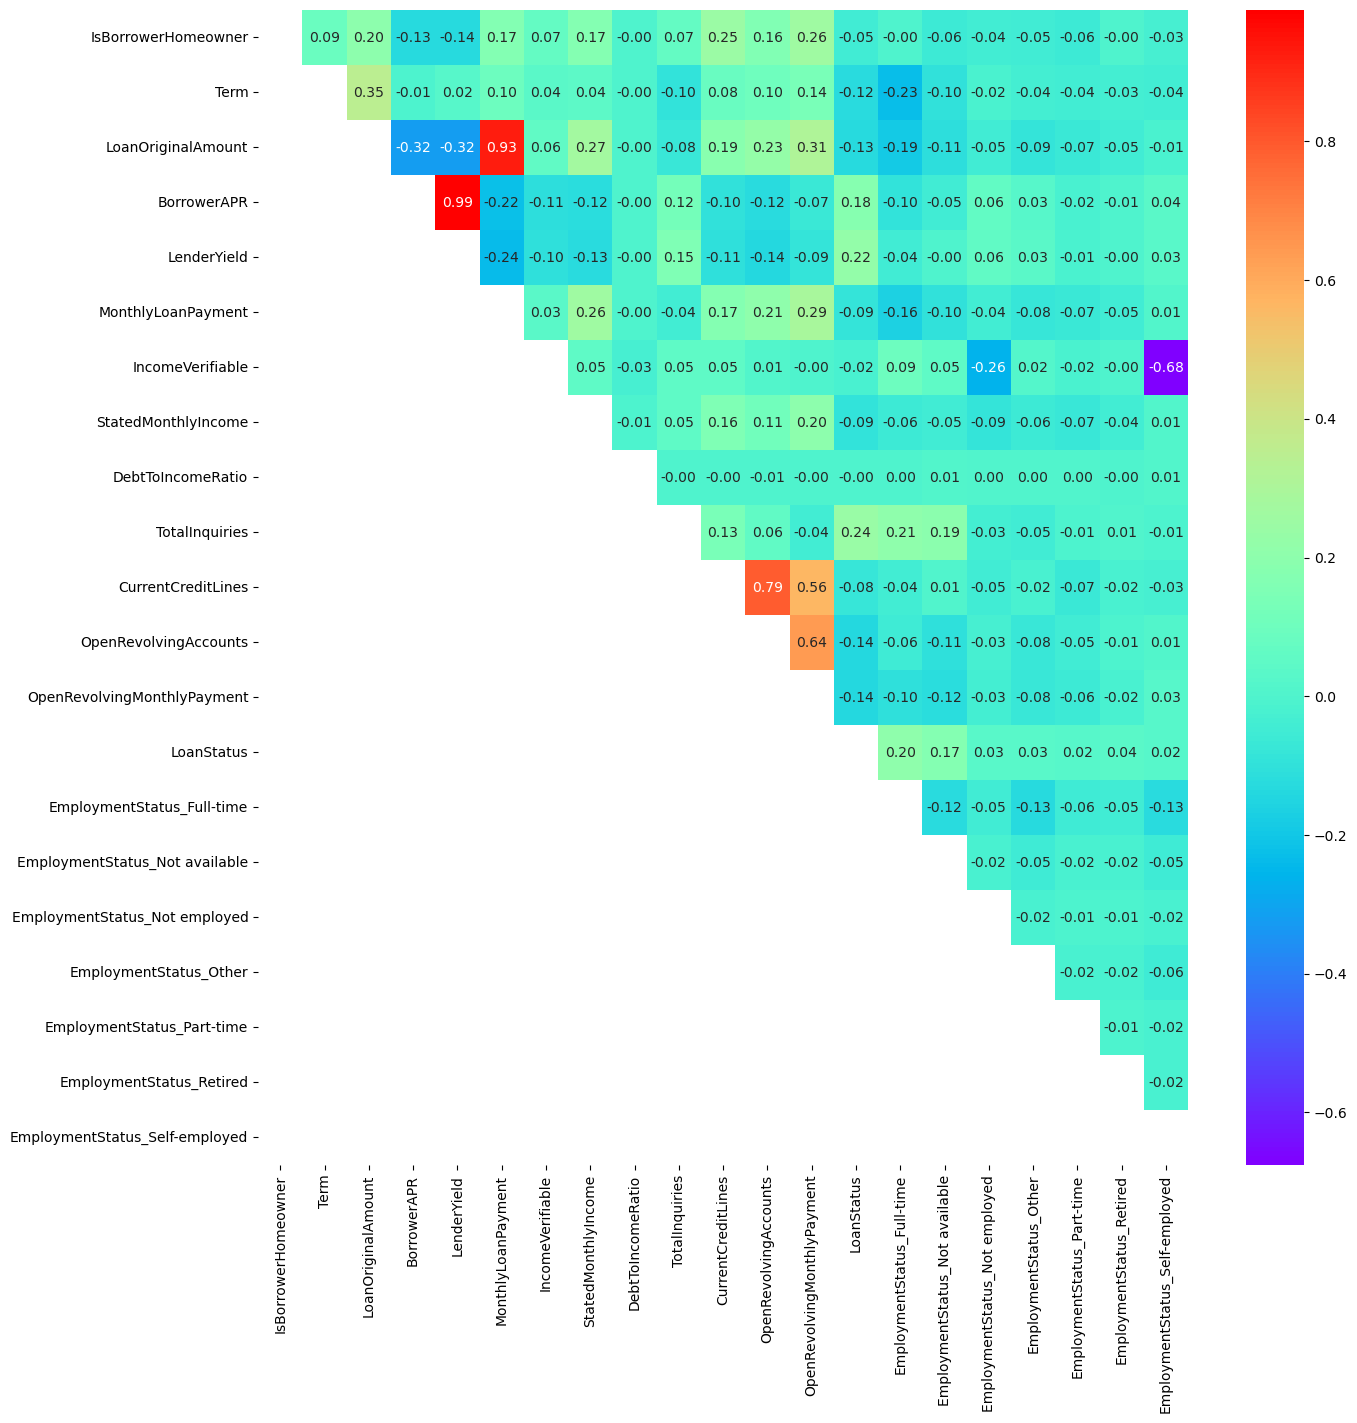

In [22]:
# Kiểm tra tương quan giữa các cột
corr=new_df_dummy.corr()
matrix = np.tril(corr)
plt.figure(figsize=(15,15))
sns.heatmap(corr, mask=matrix, cmap='rainbow', annot=True, fmt=".2f");

## 3. Xây dựng mô hình dự đoán xác suất khách hàng vỡ nợ

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, recall_score, precision_score

In [24]:
# Tách biến độc lập và phụ thuộc
x=new_df_dummy.drop(columns='LoanStatus')
y=new_df_dummy['LoanStatus']

# Chia tập train test
x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.2, random_state=1)

print(y_train.value_counts())
print(y_test.value_counts())

LoanStatus
0    72831
1    12904
Name: count, dtype: int64
LoanStatus
0    18244
1     3190
Name: count, dtype: int64


Có thể thấy số lượng lớp 1 chiếm tỉ lệ rất ít ở cả tập train và test => dữ liệu bị mất cân bằng (Imbalanced data)

**Ý tưởng xây dựng mô hình**

Ta sẽ sử dụng 3 mô hình chính gồm: Logistic, RandomForest và LightGBM với data đã resample bằng SMOTE trong dự án này.

1. Sử dụng mô hình Logistic Regression với 2 loại dữ liệu: scaling và không scaling (do RandomForest và LightGBM không cần phải thiết phải Scaling)
2. Sử dụng mô hình RandomForest và LightGBM với dữ liệu không scaling

In [25]:
# Scaling dữ liệu
scaler=StandardScaler()

x_train_scale=scaler.fit_transform(x_train)

x_test_scale=scaler.transform(x_test)

In [26]:
# Resampling data
smote=SMOTE(random_state=1)

# Resampling với data scaling
x_train_scale_sm, y_train_scale_sm=smote.fit_resample(x_train_scale, y_train)

# Resampling với data không scaling
x_train_sm, y_train_sm=smote.fit_resample(x_train, y_train)

### 3.1 Logistic

In [27]:
# Với dữ liệu không scaling
log=LogisticRegression(random_state=1)

log.fit(x_train_sm, y_train_sm)

y_pred_log=log.predict(x_test)
y_pred_prob_log=log.predict_proba(x_test)

print(classification_report(y_test, y_pred_log))
print(confusion_matrix(y_test, y_pred_log))

              precision    recall  f1-score   support

           0       0.92      0.72      0.81     18244
           1       0.29      0.66      0.41      3190

    accuracy                           0.71     21434
   macro avg       0.61      0.69      0.61     21434
weighted avg       0.83      0.71      0.75     21434

[[13172  5072]
 [ 1080  2110]]


C:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [28]:
# Với dữ liệu scaling
log.fit(x_train_scale_sm, y_train_scale_sm)

y_pred_log_scale=log.predict(x_test_scale)
y_pred_prob_log_scale=log.predict_proba(x_test_scale)

print(classification_report(y_test, y_pred_log_scale))
print(confusion_matrix(y_test, y_pred_log_scale))

              precision    recall  f1-score   support

           0       0.94      0.75      0.84     18244
           1       0.35      0.75      0.47      3190

    accuracy                           0.75     21434
   macro avg       0.65      0.75      0.66     21434
weighted avg       0.86      0.75      0.78     21434

[[13754  4490]
 [  808  2382]]


### 3.2 RandomForest

In [29]:
rfc=RandomForestClassifier(random_state=1)

rfc.fit(x_train_sm, y_train_sm)

y_pred_rfc=rfc.predict(x_test)
y_pred_prob_rfc=rfc.predict_proba(x_test)

print(classification_report(y_test, y_pred_rfc))
print(confusion_matrix(y_test, y_pred_rfc))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91     18244
           1       0.45      0.41      0.43      3190

    accuracy                           0.84     21434
   macro avg       0.67      0.66      0.67     21434
weighted avg       0.83      0.84      0.83     21434

[[16625  1619]
 [ 1869  1321]]


### 3.3 LightGBM

In [30]:
lgbm=LGBMClassifier(random_state=1, verbose=-1)

lgbm.fit(x_train_sm, y_train_sm)

y_pred_lgbm=lgbm.predict(x_test)
y_pred_prob_lgbm=lgbm.predict_proba(x_test)

print(classification_report(y_test, y_pred_lgbm))
print(confusion_matrix(y_test, y_pred_lgbm))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92     18244
           1       0.58      0.32      0.41      3190

    accuracy                           0.86     21434
   macro avg       0.73      0.64      0.67     21434
weighted avg       0.84      0.86      0.85     21434

[[17498   746]
 [ 2166  1024]]


## 4. Đánh giá mô hình (Evaluate models)

In [32]:
# Tổng hợp các chỉ số đánh giá mô hình
from imblearn.pipeline import Pipeline
rfc_sampling = Pipeline([('smote', smote), ('rfc', rfc)])
lgbm_sampling = Pipeline([('smote', smote), ('lgbm', lgbm)])
log_no_scale = Pipeline([('smote', smote), ('log', log)])
log_scale = Pipeline([('scaler', scaler), ('smote', smote), ('log', log)])

models={'Logistic Regression no Scaling':log_no_scale,
       'Logistic Regression with Scaling':log_scale,
       'RandomForest with Sampling': rfc_sampling,
       'LightGBM with sampling': lgbm_sampling
}

precision_test = {}
roc_test = {}
recall_test = {}
f1_test = {}
for name, model in models.items():
    
    model.fit(x_train, y_train)
    y_test_pred = model.predict(x_test)
    
    roc_test[name] = roc_auc_score(y_test, y_test_pred).round(4)
    recall_test[name] = recall_score(y_test, y_test_pred).round(4)
    f1_test[name] = f1_score(y_test, y_test_pred).round(4)
    precision_test[name] = precision_score(y_test, y_test_pred).round(4)

C:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [33]:
scores = pd.DataFrame([roc_test, precision_test, recall_test, f1_test], 
                      index=["roc_test", "precision_test", "recall_test", "f1_test"]).T

scores.sort_values(by=['f1_test'], ascending = [False])

,roc_test,precision_test,recall_test,f1_test
Logistic Regression with Scaling,0.7503,0.3466,0.7467,0.4735
RandomForest with Sampling,0.6627,0.4493,0.4141,0.4310
LightGBM with sampling,0.6401,0.5785,0.3210,0.4129
Logistic Regression no Scaling,0.6917,0.2938,0.6614,0.4069


## 4. Ước tính tổn thất dự kiến (trên tập test)

In [38]:
# Ghép các cột thành 1 dataframe kết quả
result_df=pd.DataFrame(y_test).reset_index(drop=True)
result_df=pd.concat([
    result_df,
    pd.DataFrame(y_pred_log, columns=['log_pred']),
    pd.DataFrame(y_pred_prob_log[:,1], columns=['log_pred_prob']),
    pd.DataFrame(y_pred_log_scale, columns=['log_scale_pred']),
    pd.DataFrame(y_pred_prob_log_scale[:,1], columns=['log_scale_pred_prob']),
    pd.DataFrame(y_pred_rfc, columns=['rfc_pred']),
    pd.DataFrame(y_pred_prob_rfc[:,1], columns=['rfc_pred_prob']),
    pd.DataFrame(y_pred_lgbm, columns=['lgbm_pred']),
    pd.DataFrame(y_pred_prob_lgbm[:,1], columns=['lgbm_pred_prob'])
], axis=1)

result_df.head()

,LoanStatus,log_pred,log_pred_prob,log_scale_pred,log_scale_pred_prob,rfc_pred,rfc_pred_prob,lgbm_pred,lgbm_pred_prob
0,0,0,0.167360,0,0.059751,0,0.01,0,0.029825
1,0,0,0.332641,0,0.359086,0,0.21,0,0.239978
2,0,1,0.834537,1,0.957024,1,0.67,1,0.673629
3,0,0,0.209621,0,0.096389,0,0.00,0,0.026269
4,0,1,0.508619,1,0.507515,0,0.25,0,0.164836


In [40]:
# Thêm cột LGD và EAD với LGD=1 và EAD=LoanOriginalAmount
result_df['LGD']=1
result_df['EAD']=x_test['LoanOriginalAmount'].reset_index(drop=True)
result_df.head()

,LoanStatus,log_pred,log_pred_prob,log_scale_pred,log_scale_pred_prob,rfc_pred,rfc_pred_prob,lgbm_pred,lgbm_pred_prob,LGD,EAD
0,0,0,0.167360,0,0.059751,0,0.01,0,0.029825,1,10000
1,0,0,0.332641,0,0.359086,0,0.21,0,0.239978,1,10639
2,0,1,0.834537,1,0.957024,1,0.67,1,0.673629,1,2800
3,0,0,0.209621,0,0.096389,0,0.00,0,0.026269,1,20000
4,0,1,0.508619,1,0.507515,0,0.25,0,0.164836,1,7000


In [42]:
# Tính EL cho từng khoản vay
result_df['log_expected_loss']=result_df['log_pred_prob']*result_df['LGD']*result_df['EAD']
result_df['log_scale_expected_loss']=result_df['log_scale_pred_prob']*result_df['LGD']*result_df['EAD']
result_df['rfc_expected_loss']=result_df['rfc_pred_prob']*result_df['LGD']*result_df['EAD']
result_df['lgbm_expected_loss']=result_df['lgbm_pred_prob']*result_df['LGD']*result_df['EAD']

result_df.head()

,LoanStatus,log_pred,log_pred_prob,log_scale_pred,log_scale_pred_prob,rfc_pred,rfc_pred_prob,lgbm_pred,lgbm_pred_prob,LGD,EAD,log_expected_loss,log_scale_expected_loss,rfc_expected_loss,lgbm_expected_loss
0,0,0,0.167360,0,0.059751,0,0.01,0,0.029825,1,10000,1673.604890,597.508610,100.00,298.247857
1,0,0,0.332641,0,0.359086,0,0.21,0,0.239978,1,10639,3538.966694,3820.313465,2234.19,2553.122505
2,0,1,0.834537,1,0.957024,1,0.67,1,0.673629,1,2800,2336.702755,2679.668573,1876.00,1886.161633
3,0,0,0.209621,0,0.096389,0,0.00,0,0.026269,1,20000,4192.411663,1927.784804,0.00,525.388847
4,0,1,0.508619,1,0.507515,0,0.25,0,0.164836,1,7000,3560.331423,3552.601935,1750.00,1153.852745


In [47]:
# Ước tính tổng EL trên từng mô hình
total_loan_amount=result_df['EAD'].sum()
total_log=result_df['log_expected_loss'].sum().round(2)
total_log_scale=result_df['log_scale_expected_loss'].sum().round(2)
total_rfc=result_df['rfc_expected_loss'].sum().round(2)
total_lgbm=result_df['lgbm_expected_loss'].sum().round(2)

print('Total Loan Amount: $%s' %(total_loan_amount))
print('Logistic Regression Expected Loss (no Scaling): $%s' %(total_log))
print('Logistic Regression Expected Loss (Scaling): $%s' %(total_log_scale))
print('Random Forest Expected Loss: $%s' %(total_rfc))
print('LightGBM Expected Loss: $%s' %(total_lgbm))

Total Loan Amount: $175677254
Logistic Regression Expected Loss (no Scaling): $60567947.16
Logistic Regression Expected Loss (Scaling): $53623763.03
Random Forest Expected Loss: $32416158.02
LightGBM Expected Loss: $24184683.85


## END!